# BPR IMPLEMENTATION

In [1]:
import torch
import torchvision
import torch.nn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from tables.table import NoSuchNodeError
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import math
import copy
warnings.filterwarnings('ignore')

In [4]:
INPUT_DIR='/content/drive/MyDrive/DSAIL/data'
OUTPUT_DIR='/content/drive/MyDrive/DSAIL/data'

In [5]:
ratings = pd.read_csv(os.path.join(INPUT_DIR, 'ratings.csv'))

In [6]:
ratings_df = ratings.drop(columns=['timestamp'])
ratings_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [7]:
#userId x moveId , cell : rating인 matrix

table_df = ratings_df.pivot_table(index='userId', columns='movieId', values ='rating')
df_matrix = table_df.to_numpy()

In [8]:
df_matrix = np.nan_to_num(df_matrix)

In [9]:
df_matrix

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [10]:
#implicit한 거니까 그냥 1과 0으로만 표현
df_matrix[df_matrix>0]=1

In [11]:
row_sums = np.sum(df_matrix,axis=1)
col_sums = np.sum(df_matrix,axis=0)

row_keep = row_sums>=10
col_keep = col_sums>=10

user_movie_data = df_matrix[row_keep][:,col_keep]

In [55]:
#확인차 써보는 코드
user_movie_data.shape[0]

610

In [68]:
tmp = np.nonzero(user_movie_data[0])[0]
filter_tmp = tmp[tmp!=2]
print(tmp)
print(filter_tmp)
print(user_movie_data[0][tmp])

[   0    2    4   34   36   43   55   59   71   74   80  106  109  114
  118  131  148  156  165  173  178  181  184  208  216  221  229  239
  250  263  266  267  276  277  278  281  285  294  296  299  310  311
  323  367  370  380  399  400  403  404  405  406  412  414  417  420
  424  429  430  432  437  445  449  465  466  467  473  475  477  480
  481  486  487  489  491  501  516  518  524  528  533  536  538  546
  552  569  583  594  597  618  621  627  632  633  636  648  650  651
  655  663  680  689  695  719  722  729  740  749  754  759  761  766
  767  770  771  779  788  789  790  793  799  800  812  814  816  818
  825  827  830  839  840  841  846  860  864  868  873  883  887  894
  901  908  913  916  920  924  929  935  936  942  945  947  951  957
  958  960  961  962  965  966  976  979  987 1001 1014 1023 1028 1032
 1040 1047 1048 1049 1050 1055 1059 1061 1064 1065 1067 1077 1078 1083
 1084 1086 1106 1112 1116 1125 1128 1131 1148 1168 1181 1182 1183 1184
 1185 

In [13]:
u = np.random.choice(range(user_movie_data.shape[0]))
print(u)
u_vector = copy.deepcopy(user_movie_data[u])
print(np.where(u_vector==1))
print(np.random.choice(np.where(u_vector==1)[0]))
print(np.where(u_vector==0))
#여기까지 확인차 써보는 코드였다.

408
(array([  29,   60,  109,  118,  131,  148,  158,  225,  269,  278,  285,
        326,  346,  359,  361,  367,  376,  383,  420,  421,  422,  424,
        433,  444,  449,  463,  464,  466,  480,  486,  488,  492,  494,
        495,  498,  503,  505,  508,  516,  519,  524,  534,  536,  557,
        558,  586,  593,  619,  714,  727,  760,  766,  774,  795,  845,
        856,  867,  872,  875,  887,  925,  926,  941,  948,  952,  953,
        966,  971,  974,  977,  978,  981,  982,  984,  986,  987,  994,
       1002, 1004, 1005, 1006, 1007, 1012, 1019, 1028, 1034, 1037, 1058,
       1067, 1072, 1080, 1114, 1115, 1124, 1126, 1148, 1152, 1166, 1167,
       1176, 1190, 1201, 1206, 1211, 1234, 1258, 1269, 1276, 1280, 1281,
       1448]),)
948
(array([   0,    1,    2, ..., 2266, 2267, 2268]),)


In [19]:
user_feat = np.random.random((user_movie_data.shape[0], 20))
item_feat = np.random.random((user_movie_data.shape[1], 20))

print(user_feat[0].shape)
print(item_feat[0].shape)

(20,)
(20,)


In [50]:
class BPR:
  def __init__(self,learning_rate = 0.01, features = 20, itrs = 10, lbd = 0.01, data = None):
    self.learning_rate = learning_rate
    self.features = features
    self.itrs = itrs
    self.lbd = lbd
    self.data = data

  def fit(self):
    #일단 user x feature, item x feature를 초기에 random하게 생성
    user_feat = np.random.random((self.data.shape[0],self.features))
    item_feat = np.random.random((self.data.shape[1],self.features))

    auc = []
    predicted = []
    truevalue = []
    epochs = []

    for itr in range(1000001):
      u = np.random.choice(range(self.data.shape[0]))
      u_feat = copy.deepcopy(self.data[u])
      i = np.random.choice(np.where(u_feat==1)[0])
      j = np.random.choice(np.where(u_feat==0)[0])

      w_u = user_feat[u,:]
      h_i = item_feat[i,:]
      h_j = item_feat[j,:]

      x_uij = np.dot(w_u,h_i) - np.dot(w_u,h_j)
      exp = np.exp(-x_uij) / (1 + np.exp(-x_uij))

      grad_wu = exp * (h_i-h_j) + self.lbd * w_u
      user_feat[u,:] = user_feat[u,:] + self.learning_rate * grad_wu

      grad_hi = exp * (w_u) + self.lbd * h_i
      item_feat[i,:] = item_feat[i,:] + self.learning_rate * grad_hi

      grad_hj = exp * (-w_u) + self.lbd * h_j
      item_feat[j,:] = item_feat[j,:] + self.learning_rate * grad_hj

      if(x_uij>0):
        predicted.append(1)
      else:
        predicted.append(0)
      #해당 유저의 movie i와 movie j를 비교해서 보자.
      if(self.data[u][i]==1 and self.data[u][j]==0):
        truevalue.append(1)
      else:
        truevalue.append(0)
      if(itr%100000==0):
        if not(sum(truevalue)==0 and itr !=0):
          epochs.append(itr)
          auc.append(sum(predicted)/sum(truevalue))
          print(str(itr) + "th auc is : " + str(auc[-1]))


    return epochs, auc







In [51]:
bpr_model = BPR(0.01,20,10,0.01,user_movie_data)
epochs, auc = bpr_model.fit()

0th auc is : 0.0
100000th auc is : 0.6987430125698743
200000th auc is : 0.7413012934935326
300000th auc is : 0.7607874640417865
400000th auc is : 0.7731655670860823
500000th auc is : 0.7816644366711266
600000th auc is : 0.7880270199549667
700000th auc is : 0.7936188662587624
800000th auc is : 0.7982677521653098
900000th auc is : 0.8030046633281519
1000000th auc is : 0.807089192910807


In [53]:
print(len(auc))
print(len(epochs))

11
11


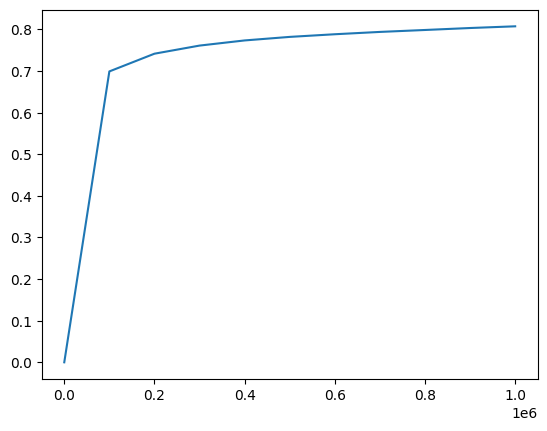

In [54]:
plt.plot(epochs, auc)
plt.show()

In [69]:
class BPR_KNN:
  def __init__(self,learning_rate = 0.01, features = 20, lbd = 0.01, data = None):
    self.learning_rate = learning_rate
    self.features = features
    self.lbd = lbd
    self.data = data
    self.c_item = np.random.random((self.data.shape[1],self.data.shape[1]))
    #temp = np.random.random((self.data.shape[1],self.data.shape[1]))
    #self.c_item =

  def fit(self):
    auc = []
    predicted = []
    truevalue = []
    epochs = []

    for itr in range(1000001):
      u = np.random.choice(range(self.data.shape[0]))
      u_feat = copy.deepcopy(self.data[u])
      i = np.random.choice(np.where(u_feat==1)[0])
      j = np.random.choice(np.where(u_feat==0)[0])

      #C에서 읽도록 u가 ratings에서 (i제외) 평가했던 항목들의 위치를 읽어온다.
      compare_list_temp_i = np.nonzero(self.data[u])[0]
      compare_location_i = compare_list_temp_i[compare_list_temp_i!=i]

      #c_il 들 의 위치를 위해 우선 ith row를 지정하고 나머지는 compare list의 위치로 찾아준다. 여기엔 이제 위치가 아니라 cli의 값들이 담긴거야.
      compare_list_i = self.c_item[i][compare_location_i]
      x_ui = np.sum(compare_list_i)

      #j에대해 동일과정 반복. [0]은 (list,공백)인 형태로 나와서 해준거다.
      compare_list_temp_j = np.nonzero(self.data[u])[0]
      compare_location_j = compare_list_temp_j[compare_list_temp_j!=j]

      compare_list_j = self.c_item[j][compare_location_j]
      x_uj = np.sum(compare_list_j)

      x_uij = x_ui-x_uj
      exp = np.exp(-x_uij) / (1 + np.exp(-x_uij))

      grad_ci = exp * 1 + self.lbd * self.c_item[i, compare_location_i]
      grad_cj = exp * (-1) + self.lbd * self.c_item[j, compare_location_j]

      #이제 갱신을 해주었다. c를
      self.c_item[i,compare_location_i] = self.c_item[i,compare_location_i] + self.learning_rate * grad_ci
      self.c_item[j,compare_location_j] = self.c_item[j,compare_location_j] + self.learning_rate * grad_cj

      if(x_uij>0):
        predicted.append(1)
      else:
        predicted.append(0)
      #해당 유저의 movie i와 movie j를 비교해서 보자.
      if(self.data[u][i]==1 and self.data[u][j]==0):
        truevalue.append(1)
      else:
        truevalue.append(0)
      if(itr%100000==0):
        if not(sum(truevalue)==0 and itr !=0):
          epochs.append(itr)
          auc.append(sum(predicted)/sum(truevalue))
          print(str(itr) + "th auc is : " + str(auc[-1]))


    return epochs, auc

In [71]:
knn_model = BPR_KNN(0.01,20,0.01,user_movie_data)
knn_epochs, knn_auc = knn_model.fit()

0th auc is : 0.0
100000th auc is : 0.6547934520654793
200000th auc is : 0.7246463767681162
300000th auc is : 0.7656807810640631
400000th auc is : 0.7944155139612151
500000th auc is : 0.815740368519263
600000th auc is : 0.8329336117773137
700000th auc is : 0.8467387903731566
800000th auc is : 0.8581201773497783
900000th auc is : 0.8676545914948983
1000000th auc is : 0.8759261240738759


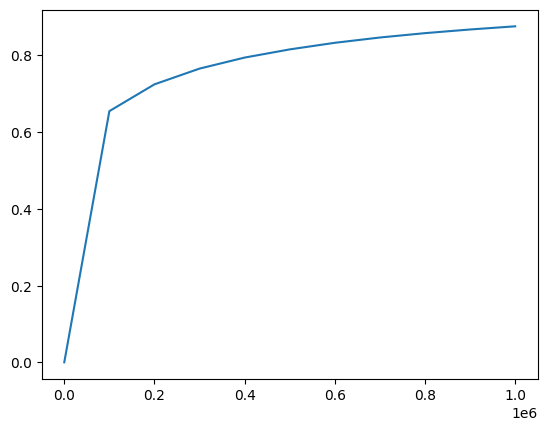

In [72]:
plt.plot(knn_epochs, knn_auc)
plt.show()